#Software de Identificación de microplásticos

In [1]:
#instalaciones requeridas
!pip install reverse_geocode
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.2 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-jp0nt692
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-jp0nt692
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2a420edb307c9bdf640f036d3b196bed474b8593
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.

In [2]:
#Librerías

#De uso general
import os #Para funcionalidades dependientes del sistema operativo
import cv2 #Para el procesamiento de imágenes
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt #Para crear gráficos
import numpy as np #Para operar funciones, vectores y matrices
import pandas as pd #Para manipulación y análisis de datos
from PIL import Image #Para abrir, manipular y guardar imágenes en varios formatos
import json #Para codificar y decodificar datos en formato JSON

#Conjunto de librerías para geolocalización
import reverse_geocode #Para convertir coordenadas geográficas (latitud y longitud) en direcciones o nombres de lugares
import folium #Para la creación de mapas interactivos
from IPython.display import display

%matplotlib inline
#Conjunto de librerías para la detección de objetos
import torch #ML basada en el cálculo automático de gradientes y en redes neuronales profundas.
import detectron2 #Detección de objetos.
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer
import logging #Para registrar eventos y mensajes durante la ejecución del programa
from detectron2.utils.logger import setup_logger
from roboflow import Roboflow #Ofrece datasets y herramientas para el entrenamiento de modelos


In [3]:
##Bienvenida
print("Bienvenido al Software de conteo y reconocimiento de microplásticos")
print("Recuerda:")
print("1-.Tener a la mano tu ubicación")
print("2-.La fotos deben ser de microplásticos filtrados es decir sin ningún otro material en lo posible")
print("3-.Las fotos deben ser claras para obtener mejores resultados")

Bienvenido al Software de conteo y reconocimiento de microplásticos
Recuerda:
1-.Tener a la mano tu ubicación
2-.La fotos deben ser de microplásticos filtrados es decir sin ningún otro material en lo posible
3-.Las fotos deben ser claras para obtener mejores resultados


##Modelo de Conteo de microplásticos

In [4]:
#Descarga y configuración del dataset
rf = Roboflow(api_key="Dlwgwe3psTHRPIuQlsbV")
project = rf.workspace("panats-mp-project").project("microplastic-dataset")
dataset = project.version(19).download("coco")

#Definición de rutas y nombres
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

#Registro del dataset
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

#Validación del dataset
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

# Configuración del modelo
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (VALID_DATA_SET_NAME,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7  # Número de categorías de microplásticos


# Creación del entrenador
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Configuración del modelo
cfg.MODEL.WEIGHTS = "./output/model_final.pth"  # Ruta a los pesos del modelo entrenado
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Umbral para la predicción
cfg.DATASETS.TEST = ("microplastic-dataset-valid", )

predictor = DefaultPredictor(cfg) #Predictor


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Microplastic-Dataset-19 in coco:: 100%|██████████| 787/787 [00:00<00:00, 6326.03it/s]


[07/20 09:46:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 104MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[07/20 09:46:24 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)


[07/20 09:46:35 d2.utils.events]:  eta: 0:15:43  iter: 19  total_loss: 3.47  loss_cls: 2.054  loss_box_reg: 0.7498  loss_rpn_cls: 0.6604  loss_rpn_loc: 0.06924    time: 0.3131  last_time: 0.3174  data_time: 0.0155  last_data_time: 0.0047   lr: 1.9981e-05  max_mem: 1840M
[07/20 09:46:44 d2.utils.events]:  eta: 0:15:42  iter: 39  total_loss: 2.911  loss_cls: 1.704  loss_box_reg: 0.8517  loss_rpn_cls: 0.3379  loss_rpn_loc: 0.07616    time: 0.3198  last_time: 0.2518  data_time: 0.0135  last_data_time: 0.0059   lr: 3.9961e-05  max_mem: 1840M
[07/20 09:46:51 d2.utils.events]:  eta: 0:15:41  iter: 59  total_loss: 2.281  loss_cls: 1.113  loss_box_reg: 0.8588  loss_rpn_cls: 0.1917  loss_rpn_loc: 0.09169    time: 0.3209  last_time: 0.3085  data_time: 0.0088  last_data_time: 0.0051   lr: 5.9941e-05  max_mem: 1840M
[07/20 09:46:57 d2.utils.events]:  eta: 0:15:47  iter: 79  total_loss: 1.751  loss_cls: 0.698  loss_box_reg: 0.8623  loss_rpn_cls: 0.1006  loss_rpn_loc: 0.08954    time: 0.3228  last_ti

##Ingreso de un fotografía de microplásticos para analizar y de ubicación

Ingrese el nombre del archivo de la imagen (con extensión): /content/d--52-_jpg.rf.086e80a05c54229e7189ec3bc38c9940.jpg
Ingrese la latitud: -0.828698914155737
Ingrese la longitud: -90.82966201810576
Ingrese la descripción de la ubicación (opcional): Galápagos


Los resultados se han guardado en 'microplastico_y_ubicaciones.csv'.

Resumen del conteo de microplásticos:
Verde: 0
Azul: 0
Amarillo: 0
Blanco: 1
Rojo: 2

Total de microplásticos detectados: 3
Imagen con los rectángulos guardada en '/content/Microplastic-Dataset-19/valid/image_with_boxes.jpg'.


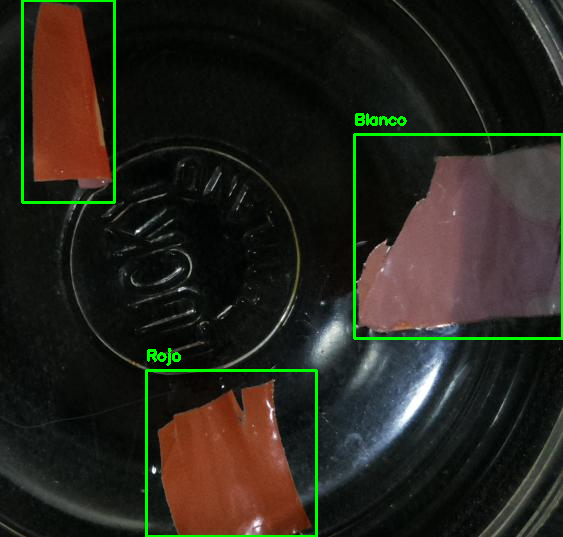

    Color  Conteo             Latitud            Longitud     País Descripción
0  Blanco       1  -0.828698914155737  -90.82966201810576  Ecuador   Galápagos
1    Rojo       2                 NaN                 NaN      NaN         NaN
2   Total       3                 NaN                 NaN      NaN         NaN
Gracias :)


In [5]:
# Ruta para guardar el archivo CSV
archivo_csv = 'microplastico_y_ubicaciones.csv'

# Cargar los datos desde el archivo JSON
with open("data.json", "r") as json_file:
    data_loaded = json.load(json_file)

# Acceder a los datos
latitud = data_loaded["latitud"]
longitud = data_loaded["longitud"]
uploaded_filename = data_loaded["imagen"]




# Solicitar al usuario que ingrese el nombre del archivo de imagen
image_filename = input("Ingrese el nombre del archivo de la imagen (con extensión): ")
print(f"{uploaded_filename}")

# Leer la imagen
image_path = os.path.join(VALID_DATA_SET_IMAGES_DIR_PATH, image_filename)
image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"La imagen '{image_filename}' no se encuentra en la ruta '{VALID_DATA_SET_IMAGES_DIR_PATH}'.")

# Detectar microplásticos
outputs = predictor(image)
instances = outputs["instances"].to("cpu")
pred_boxes = instances.pred_boxes.tensor.numpy()  # Coordenadas de las cajas delimitadoras

# Convertir la imagen a HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Definir los rangos de color en HSV
color_ranges = {
    "Verde": ((0, 0, 200), (180, 30, 255)),
    "Azul": ((100, 150, 0), (140, 255, 255)),
    "Amarillo": ((20, 100, 100), (30, 255, 255)),
    "Blanco": ((40, 40, 40), (80, 255, 255)),
    "Rojo": ((0, 100, 100), (10, 255, 255)),
}

# Contar los microplásticos por color
color_counts = {color: 0 for color in color_ranges}

# Función para encontrar el color más cercano
def get_closest_color(hsv_image, x, y, w, h):
    roi = hsv_image[y:y+h, x:x+w]
    mean_color = cv2.mean(roi)[:3]
    min_dist = float('inf')
    closest_color = None
    for color, (lower, upper) in color_ranges.items():
        lower_bound = np.array(lower, dtype="uint8")
        upper_bound = np.array(upper, dtype="uint8")
        mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
        mask_mean_color = cv2.mean(hsv_image, mask=mask)[:3]
        dist = np.linalg.norm(np.array(mean_color) - np.array(mask_mean_color))
        if dist < min_dist:
            min_dist = dist
            closest_color = color
    return closest_color

# Contar y asignar colores a cada microplástico detectado
microplastico_data = []
for box in pred_boxes:
    x1, y1, x2, y2 = box
    x, y, w, h = int(x1), int(y1), int(x2 - x1), int(y2 - y1)
    color = get_closest_color(hsv_image, x, y, w, h)
    if color:
        color_counts[color] += 1
        # Dibujar la caja delimitadora y el color en la imagen
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, color, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        # Agregar los datos al microplastico_data
        microplastico_data.append([color, x, y, w, h])

# Función para solicitar la entrada de datos
def solicitar_datos():
    latitud = input("Ingrese la latitud: ")
    print(f"Latitud: {latitud}")
    longitud = input("Ingrese la longitud: ")
    print(f"Longitud: {longitud}")
    descripcion = input("Ingrese la descripción de la ubicación (opcional): ")
    pais = obtener_pais(latitud, longitud)
    if not descripcion:
        descripcion = f'Ubicación: {latitud}, {longitud}, País: {pais}'
    mapa = folium.Map(location=[float(latitud), float(longitud)], zoom_start=15)
    folium.Marker(
        location=[float(latitud), float(longitud)],
        popup=descripcion,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(mapa)
    display(mapa)
    return [latitud, longitud, pais, descripcion]

# Función para obtener información de la ubicación basada en coordenadas
def obtener_pais(lat, lon):
    results = reverse_geocode.search([(float(lat), float(lon))])
    if results:
        return results[0]['country']
    return 'Desconocido'

# Solicitar los datos
ubicacion_data = []
entrada = solicitar_datos()
if entrada:
    ubicacion_data.append(entrada)

# Contar los microplásticos por color y exportar a CSV
data = {
    "Color": [],
    "Conteo": []
}

total_microplasticos = 0
for color, count in color_counts.items():
    if count > 0:
        data["Color"].append(color)
        data["Conteo"].append(count)
        total_microplasticos += count

# Agregar el total de microplásticos
data["Color"].append("Total")
data["Conteo"].append(total_microplasticos)

# Convertir a DataFrame y exportar a CSV
df_microplastico = pd.DataFrame(data)

# Agregar los datos de microplásticos y ubicaciones en el mismo CSV
df_ubicaciones = pd.DataFrame(ubicacion_data, columns=["Latitud", "Longitud", "País", "Descripción"])
df_final = pd.concat([df_microplastico, df_ubicaciones], axis=1)

df_final.to_csv(archivo_csv, index=False)

print(f"Los resultados se han guardado en '{archivo_csv}'.")

# Imprimir el resumen del conteo
print("\nResumen del conteo de microplásticos:")
for color, count in color_counts.items():
    print(f"{color}: {count}")

print(f"\nTotal de microplásticos detectados: {total_microplasticos}")

# Guardar la imagen con los rectángulos dibujados
output_image_path = os.path.join(VALID_DATA_SET_IMAGES_DIR_PATH, 'image_with_boxes.jpg')
cv2.imwrite(output_image_path, image)
print(f"Imagen con los rectángulos guardada en '{output_image_path}'.")

# Mostrar la imagen con las cajas delimitadoras y colores
cv2_imshow(image)  # Utiliza cv2.imshow en otros entornos
print(df_final)

print("Gracias :)")
